# CRR Perf Explore

Creates some CRR tables and runs various insert/update/delete operations against them.
Each set of operations is timed.

In [1]:
%xmode Verbose

Exception reporting mode: Verbose


In [2]:
import sqlite3
import os
import time
import random
import string
import matplotlib.pyplot as plt
import threading

filenames = ["./perf.db"]
connections = []

def random_str():
  ''.join(random.choices(string.ascii_lowercase, k=5))

try:
  for filename in filenames:    
    os.remove(filename)
    os.remove("{}-wal".format(filename))
    os.remove("{}-shm".format(filename))
except:
  None

  
def connect(filename):
  c = sqlite3.connect(filename)
  c.execute("PRAGMA journal_mode = WAL");
  c.execute("PRAGMA synchronous = NORMAL");
  c.enable_load_extension(True)
  c.execute("select load_extension('../../core/dist/crsqlite')")
  connections.append(c)
  return c

c = connect("./perf.db")

trials = 100
batch_size = 1000

# Create CRR tables

In [3]:
def create_crr_tables(c):
  c.execute("CREATE TABLE user (id primary key not null, name)")
  c.execute("CREATE TABLE deck (id primary key not null, owner_id, title)")
  c.execute("CREATE TABLE slide (id primary key not null, deck_id, \"order\")")
  c.execute("CREATE TABLE component (id primary key not null, type, slide_id, content)")

  c.execute("select crsql_as_crr('user')")
  c.execute("select crsql_as_crr('deck')")
  c.execute("select crsql_as_crr('slide')")
  c.execute("select crsql_as_crr('component')")

  
create_crr_tables(c)

# Create Vanilla Tables

In [4]:
c.execute("CREATE TABLE vuser (id primary key, name)")
c.execute("CREATE TABLE vdeck (id primary key, owner_id, title)")
c.execute("CREATE TABLE vslide (id primary key, deck_id, \"order\")")
c.execute("CREATE TABLE vcomponent (id primary key, type, slide_id, content)")

# Insert / Update / Delete Defs

In [5]:
def insert(pfx, count, offset):
  for i in range(count):
    c.execute("INSERT INTO {pfx}user VALUES (?, ?)".format(pfx = pfx), (i + offset, random_str()))
    c.execute("INSERT INTO {pfx}deck VALUES (?, ?, ?)".format(pfx = pfx), (i + offset, i + offset, random_str()))
    c.execute("INSERT INTO {pfx}slide VALUES (?, ?, ?)".format(pfx = pfx), (i + offset, i + offset, i))
    c.execute("INSERT INTO {pfx}component VALUES (?, ?, ?, ?)".format(pfx = pfx), (i + offset, "text", i + offset, random_str()))
    c.commit()

def update(pfx, count, offset):
  for i in range(count):
    c.execute("UPDATE {pfx}user SET name = ? WHERE id = ?".format(pfx = pfx), (random_str(), i + offset))
    c.execute("UPDATE {pfx}deck SET title = ? WHERE id = ?".format(pfx = pfx), (random_str(), i + offset))
    c.execute("UPDATE {pfx}slide SET \"order\" = ? WHERE id = ?".format(pfx = pfx), (i + 1, i + offset))
    c.execute("UPDATE {pfx}component SET content = ? WHERE id = ?".format(pfx = pfx), (random_str(), i + offset))
    if c.in_transaction:
      c.commit()

def read(pfx, count, offset):
  for i in range(count):
    c.execute("SELECT * FROM {pfx}user WHERE id = {id}".format(pfx = pfx, id = i + offset))
    c.execute("SELECT * FROM {pfx}deck WHERE id = {id}".format(pfx = pfx, id = i + offset))
    c.execute("SELECT * FROM {pfx}slide WHERE id = {id}".format(pfx = pfx, id = i + offset))
    c.execute("SELECT * FROM {pfx}component WHERE id = {id}".format(pfx = pfx, id = i + offset))

def single_stmt_insert(pfx, count, offset):
  values = []
  offset = offset + 1000000;
  for i in range(count):
    values.append("({}, '{}', {}, '{}')".format(i + offset, "text", i, random_str()))
  sql = "INSERT INTO {pfx}component VALUES {values}".format(pfx = pfx, values = ", ".join(values))
  c.execute(sql)
  c.commit()

def time_x(type, fn):
  timings = []

  # do N trials
  for i in range(trials):
    start = time.perf_counter_ns()
    fn(type, batch_size, batch_size * i)
    end = time.perf_counter_ns()
    timings.append((end-start)/1000000)
  
  return timings

def plot_timings(crr, vanilla, title):
  plt.plot(crr, color='blue', marker='o',mfc='navy' )
  plt.plot(vanilla, color='red', marker='x',mfc='pink' )
  plt.xticks(range(0,len(crr)+1, 1))

  plt.ylabel('time')
  plt.xlabel('trial')
  plt.title(title)
  plt.show()

def plot_xincrease(crr, vanilla, title):
  multiple = [c / v for c,v in zip(crr, vanilla)]
  plt.plot(multiple, color='brown', marker='o',mfc='red' )
  plt.xticks(range(0,len(crr)+1, 1))

  plt.ylabel('x')
  plt.xlabel('trial')
  plt.title(title)
  plt.show()


# Insert

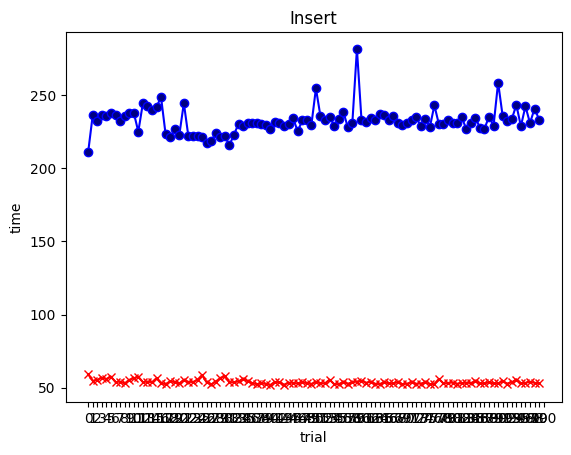

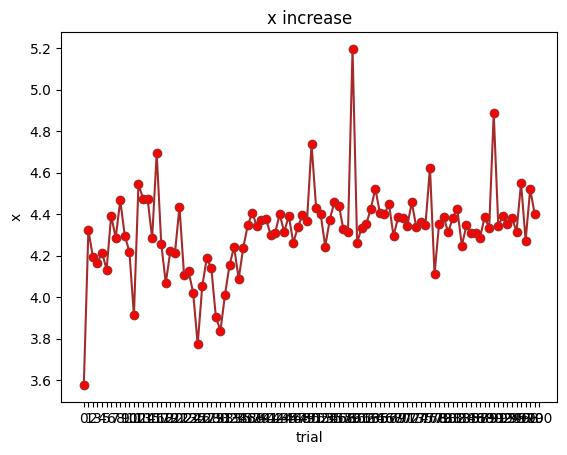

In [6]:
perf_vanilla_insert = time_x("v", insert)
perf_crr_insert = time_x("", insert)

plot_timings(perf_crr_insert, perf_vanilla_insert, "Insert")
plot_xincrease(perf_crr_insert, perf_vanilla_insert, "x increase")

# Update

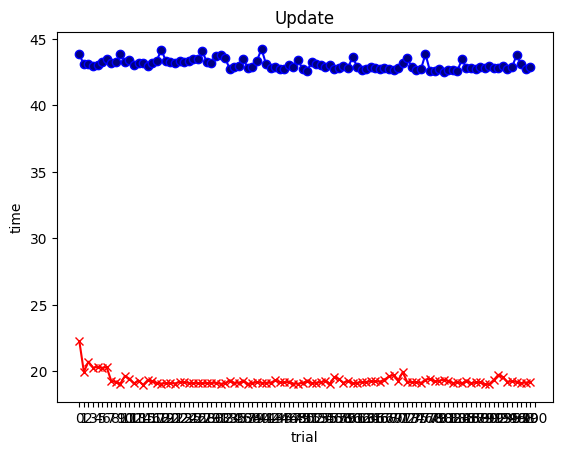

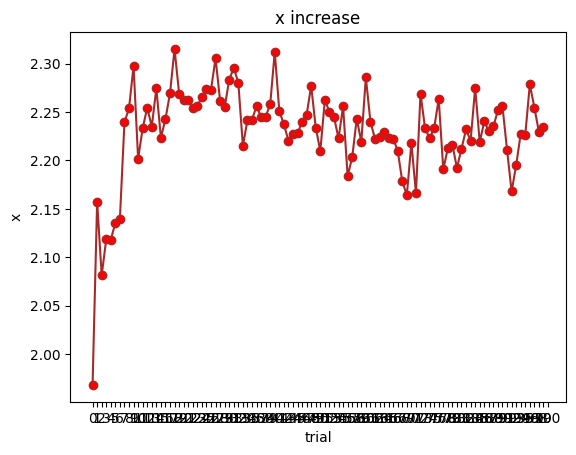

In [7]:
perf_vanilla_update = time_x("v", update)
perf_crr_update = time_x("", update)

plot_timings(perf_crr_update, perf_vanilla_update, "Update")
plot_xincrease(perf_crr_update, perf_vanilla_update, "x increase")

# Read

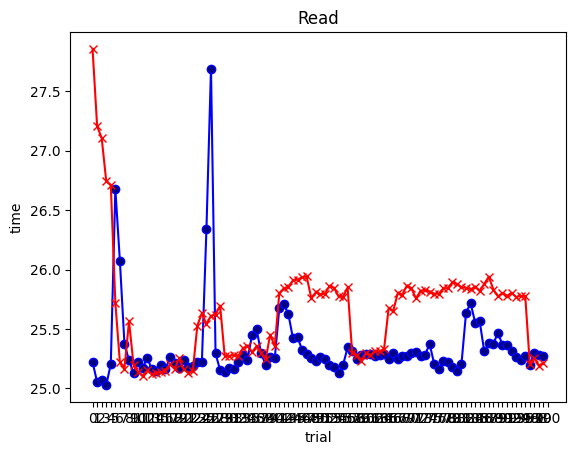

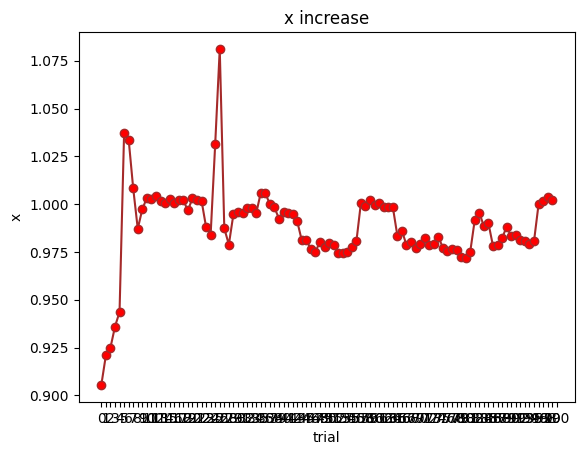

In [8]:
perf_vanilla_read = time_x("v", read)
perf_crr_read = time_x("", read)

plot_timings(perf_crr_read, perf_vanilla_read, "Read")
plot_xincrease(perf_crr_read, perf_vanilla_read, "x increase")

# Single Stmt Insert

Encodes all the inserts into a single SQL statement.

9/27/2023 Note: Looks like the `trigger_fn` update tanked perf on single statement inserts. How can we recover it?

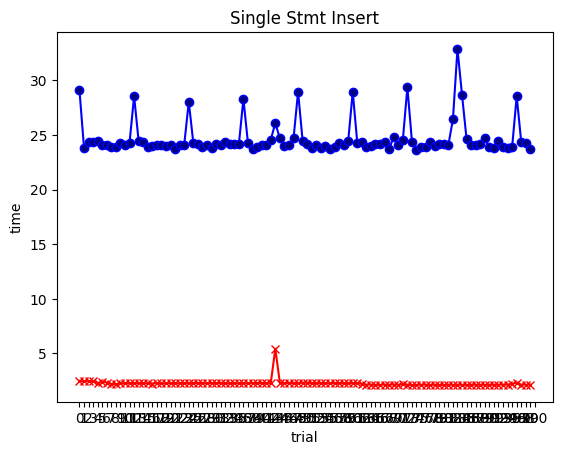

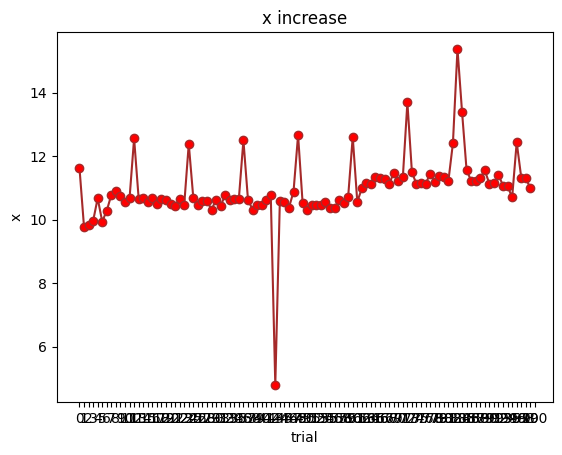

In [9]:
perf_vanilla_single = time_x("v", single_stmt_insert)
perf_crr_single = time_x("", single_stmt_insert)

plot_timings(perf_crr_single, perf_vanilla_single, "Single Stmt Insert")
plot_xincrease(perf_crr_single, perf_vanilla_single, "x increase")

# Read from crsql_changes

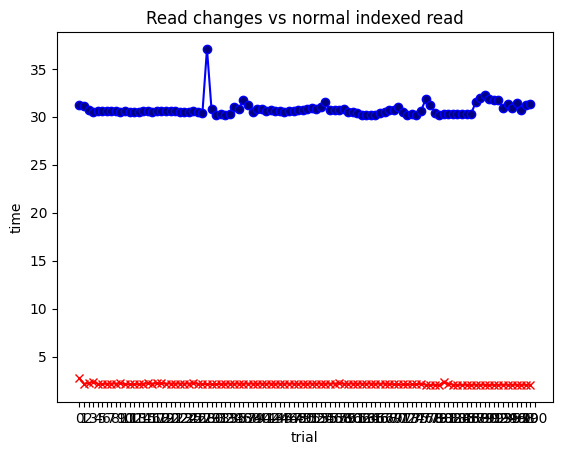

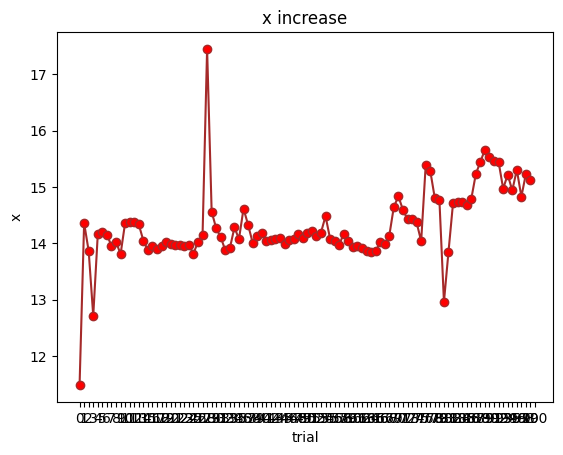

In [10]:
batch_size = 100
trials = 100
# time a read from the component table by id against a read from crsql_changes by db_version. Should be roughly the same?
def read_changes(pfx, count, offset):
  for i in range(count):
    if pfx == "v":
      c.execute("SELECT id FROM component WHERE id > ? LIMIT 100", (i + offset,)).fetchall()
    else:
      c.execute("SELECT db_version FROM crsql_changes WHERE db_version > ? LIMIT 100", (i + offset,)).fetchall()

perf_vanilla_read_something = time_x("v", read_changes)
perf_crr_read_changes = time_x("", read_changes)

plot_timings(perf_crr_read_changes, perf_vanilla_read_something, "Read changes vs normal indexed read")
plot_xincrease(perf_crr_read_changes, perf_vanilla_read_something, "x increase")

# Merging Changesets

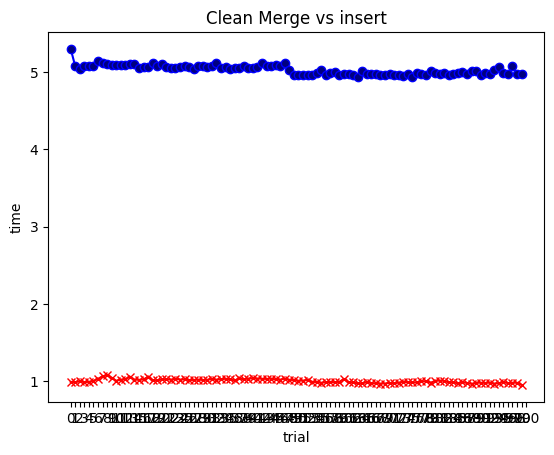

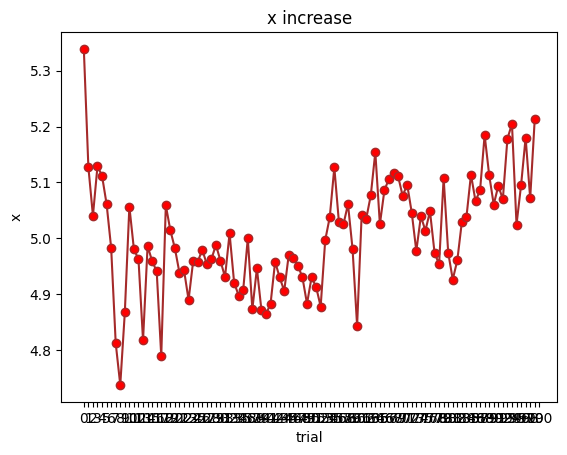

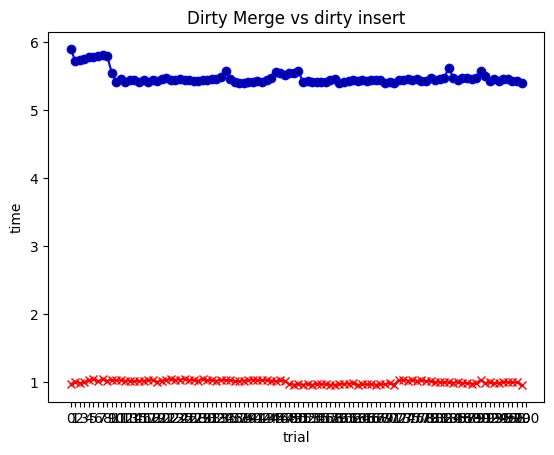

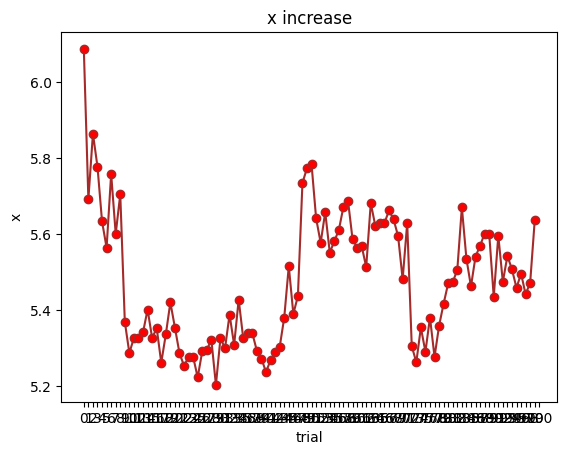

In [11]:
# compare against inert to regular table?
# need to compare
# - merge as insert
# - merge as version updates
# - merge as ties
# - merge as delete
# Best way?
# 1. Spin up a new DB
# 2. Apply same schema
# 3. Make a bunch of inserts to it (
# 4. Merge into base perf DB
# 5. Update
# 6. Merge
# 7. Delete
# 8. Merge
# create "batch size" number of rows
# and on each trial.. merge the next batch?

def create_merge_control(c):
  c.execute("CREATE TABLE merge_control (id PRIMARY KEY, tx INTEGER, content TEXT)")
  c.execute("CREATE INDEX merge_control_tx ON merge_control (tx)")
  c.commit()

def setup_merge_test_db():
  c = sqlite3.connect(":memory:")
  c.enable_load_extension(True)
  c.execute("select load_extension('../../core/dist/crsqlite')")
  create_crr_tables(c)
  
  create_merge_control(c)

  for t in range(trials):
    offset = t * batch_size
    for i in range(batch_size):
      c.execute("INSERT INTO user VALUES (?, ?)", (i + offset, random_str()))
      c.execute("INSERT INTO deck VALUES (?, ?, ?)", (i + offset, i + offset, random_str()))
      c.execute("INSERT INTO slide VALUES (?, ?, ?)", (i + offset, i + offset, i))
      c.execute("INSERT INTO component VALUES (?, ?, ?, ?)", (i + offset, "text", i + offset, random_str()))
      
      j = i * 4
      c.execute("INSERT INTO merge_control VALUES (?, ?, ?), (?, ?, ?), (?, ?, ?), (?, ?, ?)", 
               (j + offset * 4, t, random_str(), j + 1 + offset * 4, t, random_str(), j + 2 + offset * 4, t, random_str(), j + 3 + offset * 4, t, random_str()))
    c.commit() # each batch is 1 tx so we can get changes per batch for merge
  
  return c

def modify_rows(c):
  for t in range(trials):
    offset = t * batch_size
    for i in range(batch_size):
      c.execute("UPDATE user SET name = ? WHERE id = ?", (random_str(), i + offset))
      c.execute("UPDATE deck SET title = ? WHERE id = ?", (random_str(), i + offset))
      c.execute("UPDATE component SET content = ? WHERE id = ?", (random_str(), i + offset))
    c.commit() # each batch is 1 tx so we can get changes per batch for merge

merge_from = setup_merge_test_db()
merge_to = setup_merge_test_db()

def merge(pfx, count, offset):
  changes = merge_from.execute("SELECT * FROM crsql_changes WHERE db_version = ?", (offset / count + 1, ))
  for change in changes:
    merge_to.execute("INSERT INTO crsql_changes VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)", change)
  merge_to.commit()

# def merge_noop
# def merge_updates
# def merge_deletes

def normal_insert(pfx, count, offset):
  rows = merge_from.execute("SELECT * FROM merge_control WHERE tx = ?", (offset / count,))
  for row in rows:
    merge_to.execute("INSERT OR REPLACE INTO merge_control VALUES (?, ?, ?)", row)
  merge_to.commit()
  

perf_merge = time_x("", merge)
perf_insert = time_x("", normal_insert)

plot_timings(perf_merge, perf_insert, "Clean Merge vs insert")
plot_xincrease(perf_merge, perf_insert, "x increase")

modify_rows(merge_from)
perf_merge = time_x("", merge)
perf_insert = time_x("", normal_insert)

plot_timings(perf_merge, perf_insert, "Dirty Merge vs dirty insert")
plot_xincrease(perf_merge, perf_insert, "x increase")


merge_from.execute("SELECT crsql_finalize()")
merge_from.close()
merge_to.execute("SELECT crsql_finalize()")
merge_to.close()

# Concurrent Queries

In [12]:
def time_chunk(type, fn, chunk_s, chunk_e):
  timings = []

  # do N trials
  for i in range(chunk_e - chunk_s):
    start = time.perf_counter_ns()
    fn(type, chunk_e - chunk_s, chunk_s)
    end = time.perf_counter_ns()
    timings.append((end-start)/1000000)
  
  return timings

In [13]:
# for c in connections:
#   c.execute("SELECT crsql_finalize()")
#   c.close()

## Concurrent Updates

In [14]:

# We can't do this yet. We need a connection per thread 
# we can conn to same memory db like this:
# cacheDB = SqliteDatabase('file:cachedb?mode=memory&cache=shared', uri=True)
# threads = list()
# concurrency = 4
# for i in range(concurrency):
#   chunk_s = i * int(trials / concurrency)
#   chunk_e = chunk_s + int(trials / concurrency)
#   t = threading.Thread(target=time_chunk, args=("", update, chunk_s, chunk_e))
#   threads.append(t)
#   t.start()

# timings = list()
# for index, thread in enumerate(threads):
#   timings.append(thread.join())


# Debug

In [15]:
# offset changes reads from vtab

# Insert data that already exists

# Delete